In [114]:
import numpy as np
import matplotlib.pyplot as plt
import PIL

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
np.load.__defaults__=(None, True, True, 'ASCII')

In [115]:
class HParams():
    def __init__(self):
        self.data_location = '../Datasets/cat.npz'
        self.enc_hidden_size = 256
        self.dec_hidden_size = 512
        self.Nz = 128
        self.M = 20
        self.dropout = 0.9
        self.batch_size = 100
        self.eta_min = 0.01
        self.R = 0.99995
        self.KL_min = 0.2
        self.wKL = 0.5
        self.lr = 0.001
        self.lr_decay = 0.9999
        self.min_lr = 0.00001
        self.grad_clip = 1.
        self.temperature = 0.4
        self.max_seq_length = 200

hp = HParams()

In [116]:
def max_size(data):
    """larger sequence length in the data set"""
    sizes = [len(seq) for seq in data]
    return max(sizes)

def purify(strokes):
    """removes to small or too long sequences + removes large gaps"""
    data = []
    for seq in strokes:
        if seq.shape[0] <= hp.max_seq_length and seq.shape[0] > 10:
            seq = np.minimum(seq, 1000)
            seq = np.maximum(seq, -1000)
            seq = np.array(seq, dtype=np.float32)
            data.append(seq)
    return data

def calculate_normalizing_scale_factor(strokes):
    """Calculate the normalizing factor explained in appendix of sketch-rnn."""
    data = []
    for i in range(len(strokes)):
        for j in range(len(strokes[i])):
            data.append(strokes[i][j, 0])
            data.append(strokes[i][j, 1])
    data = np.array(data)
    return np.std(data)

def normalize(strokes):
    """Normalize entire dataset (delta_x, delta_y) by the scaling factor."""
    data = []
    scale_factor = calculate_normalizing_scale_factor(strokes)
    for seq in strokes:
        seq[:, 0:2] /= scale_factor
        data.append(seq)
    return data

dataset = np.load(hp.data_location, encoding='latin1')
data = dataset['train']
data = purify(data)
data = normalize(data)
Nmax = max_size(data)

In [117]:
def make_batch(batch_size):
    batch_idx = np.random.choice(len(data),batch_size)
    batch_sequences = [data[idx] for idx in batch_idx]
    strokes = []
    lengths = []
    indice = 0
    for seq in batch_sequences:
        len_seq = len(seq[:,0])
        new_seq = np.zeros((Nmax,5)) # 66,5
        new_seq[:len_seq,:2] = seq[:,:2]
        new_seq[:len_seq-1,2] = 1-seq[:-1,2]
        new_seq[:len_seq,3] = seq[:,2]
        new_seq[(len_seq-1):,4] = 1
        new_seq[len_seq-1,2:4] = 0
        lengths.append(len(seq[:,0]))
        strokes.append(new_seq)
        indice += 1

    if use_cuda:
        batch = Variable(torch.from_numpy(np.stack(strokes,1)).cuda().float())
    else:
        batch = Variable(torch.from_numpy(np.stack(strokes,1)).float())
    return batch, lengths

In [118]:
def lr_decay(optimizer):
    """Decay learning rate by a factor of lr_decay"""
    for param_group in optimizer.param_groups:
        if param_group['lr']>hp.min_lr:
            param_group['lr'] *= hp.lr_decay
    return optimizer

In [119]:
class EncoderRNN(nn.Module):
    def __init__(self):
        super(EncoderRNN, self).__init__()
        # bidirectional lstm:
        self.lstm = nn.LSTM(5, hp.enc_hidden_size, \
            dropout=hp.dropout, bidirectional=True)
        # create mu and sigma from lstm's last output:
        self.fc_mu = nn.Linear(2*hp.enc_hidden_size, hp.Nz)
        self.fc_sigma = nn.Linear(2*hp.enc_hidden_size, hp.Nz)
        # active dropout:
        self.train()

    def forward(self, inputs, batch_size, hidden_cell=None):
        if hidden_cell is None:
            # then must init with zeros
            if use_cuda:
                hidden = torch.zeros(2, batch_size, hp.enc_hidden_size).cuda()
                cell = torch.zeros(2, batch_size, hp.enc_hidden_size).cuda()
            else:
                hidden = torch.zeros(2, batch_size, hp.enc_hidden_size)
                cell = torch.zeros(2, batch_size, hp.enc_hidden_size)
            hidden_cell = (hidden, cell)
        _, (hidden,cell) = self.lstm(inputs.float(), hidden_cell)
        # hidden is (2, batch_size, hidden_size), we want (batch_size, 2*hidden_size):
        hidden_forward, hidden_backward = torch.split(hidden,1,0)
        hidden_cat = torch.cat([hidden_forward.squeeze(0), hidden_backward.squeeze(0)],1)
        # mu and sigma:
        mu = self.fc_mu(hidden_cat)
        sigma_hat = self.fc_sigma(hidden_cat)
        sigma = torch.exp(sigma_hat/2.)
        # N ~ N(0,1)
        z_size = mu.size()
                                   
        if use_cuda:
            N = torch.normal(torch.zeros(z_size),torch.ones(z_size)).cuda()
        else:
            N = torch.normal(torch.zeros(z_size),torch.ones(z_size))
        z = mu + sigma*N
        # mu and sigma_hat are needed for LKL loss
        return z, mu, sigma_hat

In [120]:
class DecoderRNN(nn.Module):
    def __init__(self):
        super(DecoderRNN, self).__init__()
        # to init hidden and cell from z:
        self.fc_hc = nn.Linear(hp.Nz, 2*hp.dec_hidden_size)
        # unidirectional lstm:
        self.lstm = nn.LSTM(hp.Nz+5, hp.dec_hidden_size, dropout=hp.dropout)
        # create proba distribution parameters from hiddens:
        self.fc_params = nn.Linear(hp.dec_hidden_size,6*hp.M+3)

    def forward(self, inputs, z, hidden_cell=None):
        if hidden_cell is None:
            # then we must init from z
            hidden,cell = torch.split(F.tanh(self.fc_hc(z)),hp.dec_hidden_size,1)
            hidden_cell = (hidden.unsqueeze(0).contiguous(), cell.unsqueeze(0).contiguous())
        outputs,(hidden,cell) = self.lstm(inputs, hidden_cell)
        # in training we feed the lstm with the whole input in one shot
        # and use all outputs contained in 'outputs', while in generate
        # mode we just feed with the last generated sample:
        if self.training:
            y = self.fc_params(outputs.view(-1, hp.dec_hidden_size))
        else:
            y = self.fc_params(hidden.view(-1, hp.dec_hidden_size))
        # separate pen and mixture params:
        params = torch.split(y,6,1)
        params_mixture = torch.stack(params[:-1]) # trajectory
        params_pen = params[-1] # pen up/down
        # identify mixture params:
        pi,mu_x,mu_y,sigma_x,sigma_y,rho_xy = torch.split(params_mixture,1,2)
        # preprocess params::
        if self.training:
            len_out = Nmax+1
        else:
            len_out = 1
                                   
        pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        sigma_x = torch.exp(sigma_x.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        sigma_y = torch.exp(sigma_y.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        rho_xy = torch.tanh(rho_xy.transpose(0,1).squeeze()).view(len_out,-1,hp.M)
        mu_x = mu_x.transpose(0,1).squeeze().contiguous().view(len_out,-1,hp.M)
        mu_y = mu_y.transpose(0,1).squeeze().contiguous().view(len_out,-1,hp.M)
        q = F.softmax(params_pen).view(len_out,-1,3)
        return pi,mu_x,mu_y,sigma_x,sigma_y,rho_xy,q,hidden,cell

In [121]:
class Model():
    def __init__(self):
        if use_cuda:
            self.encoder = EncoderRNN().cuda()
            self.decoder = DecoderRNN().cuda()
        else:
            self.encoder = EncoderRNN()
            self.decoder = DecoderRNN()
        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), hp.lr)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), hp.lr)
        self.eta_step = hp.eta_min

    def make_target(self, batch, lengths):
        if use_cuda:
            eos = torch.stack([torch.Tensor([0,0,0,0,1])]*batch.size()[1]).cuda().unsqueeze(0)
        else:
            eos = torch.stack([torch.Tensor([0,0,0,0,1])]*batch.size()[1]).unsqueeze(0)
        batch = torch.cat([batch, eos], 0)
        mask = torch.zeros(Nmax+1, batch.size()[1])
        for indice,length in enumerate(lengths):
            mask[:length,indice] = 1
        if use_cuda:
            mask = mask.cuda()
        dx = torch.stack([batch.data[:,:,0]]*hp.M,2)
        dy = torch.stack([batch.data[:,:,1]]*hp.M,2)
        p1 = batch.data[:,:,2]
        p2 = batch.data[:,:,3]
        p3 = batch.data[:,:,4]
        p = torch.stack([p1,p2,p3],2)
        return mask,dx,dy,p

    def train(self, epoch):
        self.encoder.train()
        self.decoder.train()
        batch, lengths = make_batch(hp.batch_size)
        # encode:
        z, self.mu, self.sigma = self.encoder(batch, hp.batch_size)
        # create start of sequence:
        if use_cuda:
            sos = torch.stack([torch.Tensor([0,0,1,0,0])]*hp.batch_size).cuda().unsqueeze(0)
        else:
            sos = torch.stack([torch.Tensor([0,0,1,0,0])]*hp.batch_size).unsqueeze(0)
        # had sos at the begining of the batch:
        batch_init = torch.cat([sos, batch],0)
        # expend z to be ready to concatenate with inputs:
        z_stack = torch.stack([z]*(Nmax+1))
        # inputs is concatenation of z and batch_inputs
        inputs = torch.cat([batch_init, z_stack],2)
        # decode:
        self.pi, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, \
            self.rho_xy, self.q, _, _ = self.decoder(inputs, z)
        # prepare targets:
        mask,dx,dy,p = self.make_target(batch, lengths)
        # prepare optimizers:
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        # update eta for LKL:
        self.eta_step = 1-(1-hp.eta_min)*hp.R
        # compute losses:
        LKL = self.kullback_leibler_loss()
        LR = self.reconstruction_loss(mask,dx,dy,p,epoch)
        loss = LR + LKL
        # gradient step
        loss.backward()
        # gradient cliping
        nn.utils.clip_grad_norm(self.encoder.parameters(), hp.grad_clip)
        nn.utils.clip_grad_norm(self.decoder.parameters(), hp.grad_clip)
        # optim step
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        # some print and save:
        print(f"The number of epochs is: {epoch}")
        if epoch%1==0:
#             print('epoch',epoch,'loss',loss.data[0],'LR',LR.data[0],'LKL',LKL.data[0])
            self.encoder_optimizer = lr_decay(self.encoder_optimizer)
            self.decoder_optimizer = lr_decay(self.decoder_optimizer)
        if epoch%200==0:
            self.save(epoch)
            self.conditional_generation(z)

    def bivariate_normal_pdf(self, dx, dy):
        z_x = ((dx-self.mu_x)/self.sigma_x)**2
        z_y = ((dy-self.mu_y)/self.sigma_y)**2
        z_xy = (dx-self.mu_x)*(dy-self.mu_y)/(self.sigma_x*self.sigma_y)
        z = z_x + z_y -2*self.rho_xy*z_xy
        exp = torch.exp(-z/(2*(1-self.rho_xy**2)))
        norm = 2*np.pi*self.sigma_x*self.sigma_y*torch.sqrt(1-self.rho_xy**2)
        return exp/norm

    def reconstruction_loss(self, mask, dx, dy, p, epoch):
        pdf = self.bivariate_normal_pdf(dx, dy)
        LS = -torch.sum(mask*torch.log(1e-5+torch.sum(self.pi * pdf, 2)))\
            /float(Nmax*hp.batch_size)
        LP = -torch.sum(p*torch.log(self.q))/float(Nmax*hp.batch_size)
        return LS+LP

    def kullback_leibler_loss(self):
        LKL = -0.5*torch.sum(1+self.sigma-self.mu**2-torch.exp(self.sigma))\
            /float(hp.Nz*hp.batch_size)
        if use_cuda:
            KL_min = Variable(torch.Tensor([hp.KL_min]).cuda()).detach()
        else:
            KL_min = Variable(torch.Tensor([hp.KL_min])).detach()
        return hp.wKL*self.eta_step * torch.max(LKL,KL_min)

    def save(self, epoch):
        random_number = np.random.rand()
        enc_model_name = 'sketchRNN_encoder_%3f_%d.pt' % (random_number, epoch)
        enc_path = F"../Models/{enc_model_name}"
        torch.save(self.encoder.state_dict(), enc_path)
        dec_model_name = 'sketchRNN_decoder_%3f_%d.pt' % (random_number, epoch)
        dec_path = F"../Models/{dec_model_name}"
        torch.save(self.decoder.state_dict(), dec_path)
        
#         torch.save(self.encoder.state_dict(), 'encoderRNN_sel_%3f_epoch_%d.pth' % (sel,epoch))
#         torch.save(self.decoder.state_dict(), 'decoderRNN_sel_%3f_epoch_%d.pth' % (sel,epoch))

    def load(self, encoder_name, decoder_name):
        saved_encoder = torch.load(encoder_name)
        saved_decoder = torch.load(decoder_name)
        self.encoder.load_state_dict(saved_encoder)
        self.decoder.load_state_dict(saved_decoder)

    def conditional_generation(self, z):
        batch,lengths = make_batch(1)
        # should remove dropouts:
        self.encoder.train(False)
        self.decoder.train(False)
        if use_cuda:
            sos = Variable(torch.Tensor([0,0,1,0,0]).view(1,1,-1).cuda())
        else:
            sos = Variable(torch.Tensor([0,0,1,0,0]).view(1,1,-1))
        s = sos
        seq_x = []
        seq_y = []
        seq_z = []
        hidden_cell = None
        for i in range(Nmax):
            inputs = torch.cat([s,z.unsqueeze(0)],2)
            # decode:
            self.pi, self.mu_x, self.mu_y, self.sigma_x, self.sigma_y, \
                self.rho_xy, self.q, hidden, cell = \
                    self.decoder(inputs, z, hidden_cell)
            hidden_cell = (hidden, cell)
            # sample from parameters:
            s, dx, dy, pen_down, eos = self.sample_next_state()
            #------
            seq_x.append(dx)
            seq_y.append(dy)
            seq_z.append(pen_down)
            if eos:
                #print(i)
                break
        # visualize result:
        x_sample = np.cumsum(seq_x, 0)
        y_sample = np.cumsum(seq_y, 0)
        z_sample = np.array(seq_z)
        sequence = np.stack([x_sample,y_sample,z_sample]).T
        make_image(sequence)

    def sample_next_state(self):
        def adjust_temp(pi_pdf):
            pi_pdf = np.log(pi_pdf)/hp.temperature
            pi_pdf -= pi_pdf.max()
            pi_pdf = np.exp(pi_pdf)
            pi_pdf /= pi_pdf.sum()
            return pi_pdf

        # get mixture indice:
        pi = self.pi.data[0,0,:].cpu().numpy()
        pi = adjust_temp(pi)
        pi_idx = np.random.choice(hp.M, p=pi)
        # get pen state:
        q = self.q.data[0,0,:].cpu().numpy()
        q = adjust_temp(q)
        q_idx = np.random.choice(3, p=q)
        # get mixture params:
        mu_x = self.mu_x.data[0,0,pi_idx]
        mu_y = self.mu_y.data[0,0,pi_idx]
        sigma_x = self.sigma_x.data[0,0,pi_idx]
        sigma_y = self.sigma_y.data[0,0,pi_idx]
        rho_xy = self.rho_xy.data[0,0,pi_idx]
        x,y = sample_bivariate_normal(mu_x,mu_y,sigma_x,sigma_y,rho_xy,greedy=False)
        next_state = torch.zeros(5)
        next_state[0] = x
        next_state[1] = y
        next_state[q_idx+2] = 1
        if use_cuda:
            return Variable(next_state.cuda()).view(1,1,-1),x,y,q_idx==1,q_idx==2
        else:
            return Variable(next_state).view(1,1,-1),x,y,q_idx==1,q_idx==2

def sample_bivariate_normal(mu_x,mu_y,sigma_x,sigma_y,rho_xy, greedy=False):
    # inputs must be floats
    if greedy:
        return mu_x,mu_y
    mean = [mu_x, mu_y]
    sigma_x *= np.sqrt(hp.temperature)
    sigma_y *= np.sqrt(hp.temperature)
    cov = [[sigma_x * sigma_x, rho_xy * sigma_x * sigma_y],\
        [rho_xy * sigma_x * sigma_y, sigma_y * sigma_y]]
    x = np.random.multivariate_normal(mean, cov, 1)
    return x[0][0], x[0][1]

def make_image(sequence, name='_output_'):
    """plot drawing with separated strokes"""
    strokes = np.split(sequence, np.where(sequence[:,2]>0)[0]+1)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    for s in strokes:
        plt.plot(s[:,0],-s[:,1])
    print("Outputting sketch")
    plt.show()
    #name = str(epoch)+name+'.jpg'
    #plt.savefig(F"./outputs_c/{name}")
    
#     canvas = plt.get_current_fig_manager().canvas
#     canvas.draw()
#     pil_image = PIL.Image.frombytes('RGB', canvas.get_width_height(),
#                  canvas.tostring_rgb())
#     name = str(epoch)+name+'.jpg'
#     pil_image.save(F"./outputs_chair/{name}","JPEG")
#     plt.close("all")


In [122]:
# model = Model()
# for epoch in range(50001):
#     model.train(epoch)

In [123]:
# Use conditional generation function to test model

# model = Model()
# model.load('../Models/sketchRNN_encoder_0.497555_1600.pt','../Models/sketchRNN_decoder_0.497555_1600.pt')
#model.conditional_generation(94803)


## Experiment 1 - Passing random zs to the DecoderRNN to see the types of sketches produced

Train the sketchRNN (this is what we looked at on Friday). This learns an encoder, "strokes-to-Z", where Z is an embedding, and a decoder, "Z-to-strokes". This is the setup of the Ha & Eck paper. You can then take "random" values of Z to generate new random stroke sequences; 

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outputting sketch


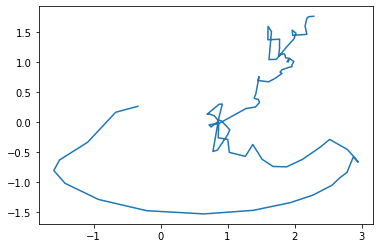

In [129]:
model = Model()

# Chose best model and sampled from gaussian to produce accurate cat images, outlier happens rarely
model.load('../Models/sketchRNN_encoder_0.320616_7000.pt','../Models/sketchRNN_decoder_0.320616_7000.pt')

# Sample z from gaussian distribution
z = torch.randn(128)
z = z.reshape(1, 128)

# Reshape z for decode
model.conditional_generation(z)

## Experiment 2 - Interpolating between 2 stroke sequences to produce a new cat!

You can do things like take two stroke sequences S1 and S2, run them through the encoder to find embeddings Z1 and Z2, and then interpolate between Z1 and Z2 before decoding in order to "interpolate" between stroke sequences. For the project writeup I think it would be nice to try to replicate some of the figures in the Ha & Eck paper using a sketchRNN that you train, if possible.

In [126]:
def convert_3_to_5(v): # v shape (stroke_len, 3)
    r = torch.zeros([v.shape[0], 5], dtype=float)
    r[:,0:2] = v[:,0:2]
    r[:,2] = v[:,2]
    r[:,3] = 1 - r[:,2]
    r[-1:4] = 1
    r = r.unsqueeze(0)
    return r

model = Model()


# Chose best model and sampled from gaussian to produce accurate cat images, outlier happens rarely
model.load('../Models/sketchRNN_encoder_0.320616_7000.pt','../Models/sketchRNN_decoder_0.320616_7000.pt')

# Get the first 2 cat sequences from data

def getSingleSequence(alreadyChosen):
    catSequences = make_batch(5)
    random_idx = numpy.random.uniform(0,len(data),1)
    while (random_idx == alreadyChosen):
        random_idx = numpy.random.uniform(0,len(data),1)
    
    return strokes[random_idx]
    

# Interpolate z_1 and z_2
def lerp(p0, p1, t):
    """Linear interpolation."""
    return (1.0 - t) * p0 + t * p1

interpolated_z = lerp(z_1, z_2)

model.conditional_generation(interpolated_z)

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:238: RuntimeWarning: covariance is not symmetric positive-semidefinite.


tensor([[-0.5910,  0.7002,  0.0000],
        [-1.2304,  0.3465,  0.0000],
        [-1.3983, -0.0449,  0.0000],
        [-1.8213, -0.0727,  0.0000],
        [-2.0998, -0.1742,  0.0000],
        [-1.9824, -0.1370,  0.0000],
        [-1.2739, -0.0835,  0.0000],
        [ 0.9709, -0.0062,  0.0000],
        [ 1.8481, -0.1400,  0.0000],
        [ 2.1907, -0.5120,  0.0000],
        [ 2.3678, -0.7409,  0.0000],
        [ 2.4782, -0.8573,  0.0000],
        [ 2.3806, -1.0655,  0.0000],
        [ 2.1680, -1.3028,  0.0000],
        [ 2.0781, -1.4564,  0.0000],
        [ 1.8740, -1.5959,  1.0000],
        [-0.3684, -0.8828,  0.0000],
        [-0.3317, -0.9383,  1.0000],
        [ 0.6168, -0.8876,  0.0000],
        [ 0.6638, -0.7447,  0.0000],
        [ 0.6334, -0.6278,  1.0000],
        [ 0.5537, -1.0984,  0.0000],
        [ 0.9479, -0.9268,  1.0000],
        [-0.1870, -1.3997,  0.0000],
        [ 0.0710, -1.9317,  1.0000],
        [ 0.0821, -1.5416,  0.0000],
        [ 0.2761, -1.7001,  1.0000],
 

RuntimeError: Expected hidden[0] size (2, 41, 256), got [2, 1, 256]